<a href="https://colab.research.google.com/github/AhsanRaza-dev/Machine-Learning-Projects/blob/main/Dog_Breed_Classification_using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial

import warnings
warnings.filterwarnings('ignore')
AUTO = tf.data.experimental.AUTOTUNE

In [3]:

df = pd.read_csv('/content/drive/MyDrive/DataSets/dog-breed-identification/labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:

df.shape

(10222, 2)

In [5]:
df['breed'].nunique()

120

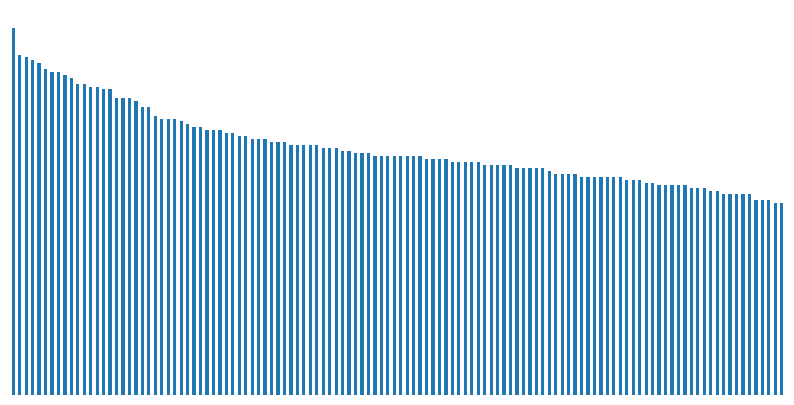

In [6]:
plt.figure(figsize=(10, 5))
df['breed'].value_counts().plot.bar()
plt.axis('off')
plt.show()

In [7]:

df['filepath'] = '/content/drive/MyDrive/DataSets/dog-breed-identification/train/' + df['id'] + '.jpg'
df.head()

,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,/content/drive/MyDrive/DataSets/dog-breed-iden...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,/content/drive/MyDrive/DataSets/dog-breed-iden...
2,001cdf01b096e06d78e9e5112d419397,pekinese,/content/drive/MyDrive/DataSets/dog-breed-iden...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,/content/drive/MyDrive/DataSets/dog-breed-iden...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,/content/drive/MyDrive/DataSets/dog-breed-iden...


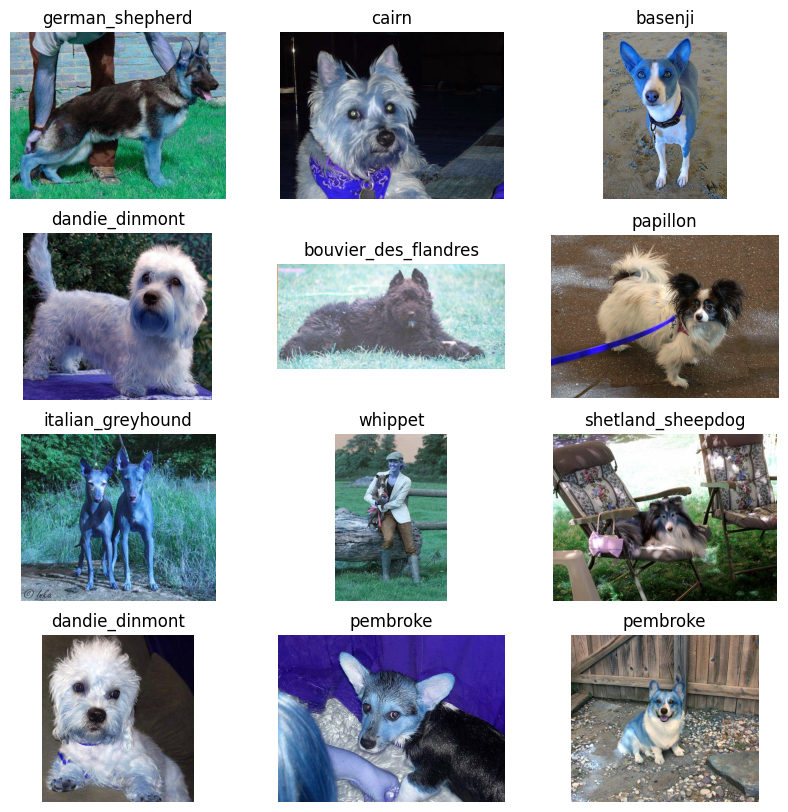

In [8]:
plt.subplots(figsize=(10, 10))
for i in range(12):
	plt.subplot(4, 3, i+1)

	# Selecting a random image
	# index from the dataframe.
	k = np.random.randint(0, len(df))
	img = cv2.imread(df.loc[k, 'filepath'])
	plt.imshow(img)
	plt.title(df.loc[k, 'breed'])
	plt.axis('off')
plt.show()


In [9]:

le = LabelEncoder()
df['breed'] = le.fit_transform(df['breed'])
df.head()

,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,19,/content/drive/MyDrive/DataSets/dog-breed-iden...
1,001513dfcb2ffafc82cccf4d8bbaba97,37,/content/drive/MyDrive/DataSets/dog-breed-iden...
2,001cdf01b096e06d78e9e5112d419397,85,/content/drive/MyDrive/DataSets/dog-breed-iden...
3,00214f311d5d2247d5dfe4fe24b2303d,15,/content/drive/MyDrive/DataSets/dog-breed-iden...
4,0021f9ceb3235effd7fcde7f7538ed62,49,/content/drive/MyDrive/DataSets/dog-breed-iden...


In [11]:
features = df['filepath']
target = df['breed']

X_train, X_val,Y_train, Y_val = train_test_split(features, target,
									test_size=0.15,
									random_state=10)

X_train.shape, X_val.shape


((8688,), (1534,))

In [12]:
import albumentations as A

transforms_train = A.Compose([
	A.VerticalFlip(p=0.2),
	A.HorizontalFlip(p=0.7),
	A.CoarseDropout(p=0.5),
	A.RandomGamma(p=0.5),
	A.RandomBrightnessContrast(p=1)
])


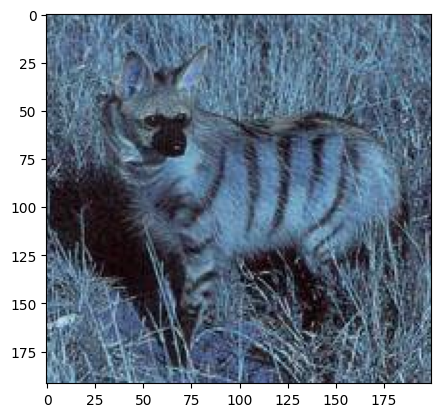

In [13]:
img = cv2.imread('/content/drive/MyDrive/DataSets/dog-breed-identification/train/00792e341f3c6eb33663e415d0715370.jpg')
plt.imshow(img)
plt.show()


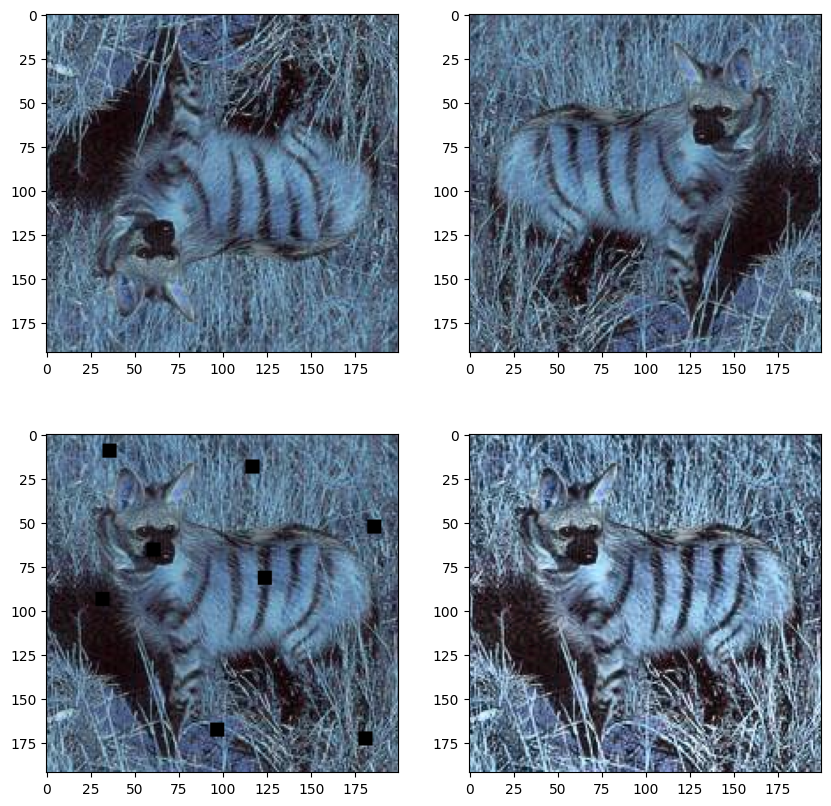

In [14]:
augments = [A.VerticalFlip(p=1), A.HorizontalFlip(p=1),
			A.CoarseDropout(p=1), A.CLAHE(p=1)]

plt.subplots(figsize=(10, 10))
for i, aug in enumerate(augments):
	plt.subplot(2, 2, i+1)
	aug_img = aug(image=img)['image']
	plt.imshow(aug_img)
plt.show()


In [15]:
def aug_fn(img):
	aug_data = transforms_train(image=img)
	aug_img = aug_data['image']

	return aug_img


@tf.function
def process_data(img, label):
	aug_img = tf.numpy_function(aug_fn,
								[img],
								Tout=tf.float32)

	return img, label


def decode_image(filepath, label=None):

	img = tf.io.read_file(filepath)
	img = tf.image.decode_jpeg(img)
	img = tf.image.resize(img, [128, 128])
	img = tf.cast(img, tf.float32) / 255.0

	if label == None:
		return img

	return img, tf.one_hot(indices=label,
						depth=120,
						dtype=tf.float32)


In [16]:
train_ds = (
	tf.data.Dataset
	.from_tensor_slices((X_train, Y_train))
	.map(decode_image, num_parallel_calls=AUTO)
	.map(partial(process_data), num_parallel_calls=AUTO)
	.batch(32)
	.prefetch(AUTO)
)

val_ds = (
	tf.data.Dataset
	.from_tensor_slices((X_val, Y_val))
	.map(decode_image, num_parallel_calls=AUTO)
	.batch(32)
	.prefetch(AUTO)
)


In [18]:
for img, label in train_ds.take(1):
  print(img.shape, label.shape)


(32, 128, 128, 3) (32, 120)


# Model Development:

In [19]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
	input_shape=(128, 128, 3),
	weights='imagenet',
	include_top=False
)


87910968/87910968 [==============================] - 1s 0us/step


In [20]:
len(pre_trained_model.layers)

311

In [22]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


last layer output shape:  (None, 6, 6, 768)


In [23]:
# Model Architecture
x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(120, activation='softmax')(x)

model = keras.Model(pre_trained_model.input, output)

# Model Compilation
model.compile(
	optimizer='adam',
	loss=keras.losses.CategoricalCrossentropy(from_logits=True),
	metrics=['AUC']
)


In [25]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_auc') > 0.99:
			print('\n Validation accuracy has reached upto 90% so, stopping further training.')
			self.model.stop_training = True

es = EarlyStopping(patience=3,
				monitor='val_auc',
				restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)


In [27]:
history = model.fit(train_ds,
					validation_data=val_ds,
					epochs=50,
					verbose=1,
					callbacks=[es, lr, myCallback()])


Epoch 1/50
272/272 [==============================] - 1201s 4s/step - loss: 3.3322 - auc: 0.8732 - val_loss: 2.5361 - val_auc: 0.9367 - lr: 0.0010
Epoch 2/50
272/272 [==============================] - 400s 1s/step - loss: 1.8544 - auc: 0.9755 - val_loss: 2.3431 - val_auc: 0.9416 - lr: 0.0010
Epoch 3/50
272/272 [==============================] - 403s 1s/step - loss: 0.8963 - auc: 0.9957 - val_loss: 2.5702 - val_auc: 0.9119 - lr: 0.0010
Epoch 4/50
272/272 [==============================] - ETA: 0s - loss: 0.3396 - auc: 0.9996
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
272/272 [==============================] - 371s 1s/step - loss: 0.3396 - auc: 0.9996 - val_loss: 2.4929 - val_auc: 0.9190 - lr: 0.0010
Epoch 5/50
272/272 [==============================] - 398s 1s/step - loss: 0.1231 - auc: 0.9999 - val_loss: 2.3062 - val_auc: 0.9263 - lr: 5.0000e-04


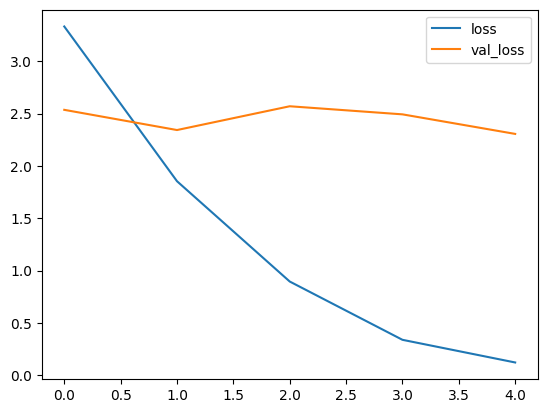

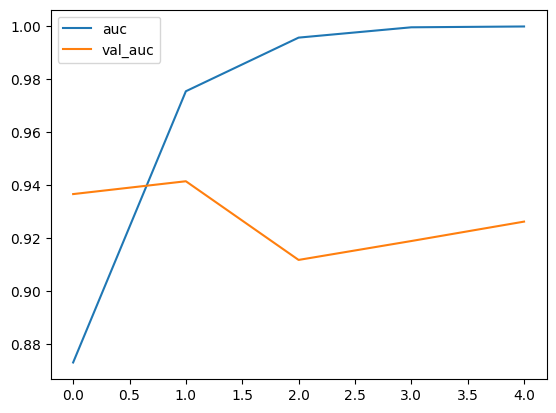

In [28]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['auc', 'val_auc']].plot()
plt.show()
